<a href="https://colab.research.google.com/github/sashamongia/Airline-Pax-Traffic/blob/main/Predicting_PassengerVolume_covid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing Packages

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from matplotlib import cm
%matplotlib inline
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 10, 5
pd.set_option('display.max_columns', 100)
import io
import requests
import warnings
import csv
np.random.seed(27)
warnings.filterwarnings('ignore')
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=DeprecationWarning)

import sklearn
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import sklearn.metrics as sm
from sklearn.metrics import confusion_matrix, classification_report
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
import statsmodels.formula.api as sm

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.feature_selection import RFE
import holidays
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.impute import SimpleImputer

# Uploading Dataset+ Data Cleaning


TSA Checkpoint dataset: Includes Dates and Passenger Inflow to the airports in USA

In [2]:
# Downloading the csv file
url = "https://raw.githubusercontent.com/sashamongia/Airline-Pax-Traffic/main/TSA%20checkpoint%20data.csv"
download = requests.get(url).content

# Reading the downloaded content and turning it into a pandas dataframe

df = pd.read_csv(io.StringIO(download.decode('utf-8')))

In [3]:
#Check column names
df.columns

Index(['Date', '2023', '2022', '2021', '2020', '2019'], dtype='object')

In [4]:
# Reshape the DataFrame using the melt() function
stacked_df = df.melt(id_vars='Date', var_name='Year', value_name='Passenger Numbers')

print(stacked_df)

           Date  Year Passenger Numbers
0      7/6/2023  2023         2,529,182
1      7/5/2023  2023         2,481,122
2      7/4/2023  2023         2,007,445
3      7/3/2023  2023         2,288,649
4      7/2/2023  2023         2,529,730
...         ...   ...               ...
1815  7/12/2022  2019         2,447,177
1816  7/11/2022  2019         2,615,115
1817  7/10/2022  2019         2,669,717
1818   7/9/2022  2019         2,312,178
1819   7/8/2022  2019         2,716,812

[1820 rows x 3 columns]


In [5]:
# Replace the year in the Date column with the year from the Year column
stacked_df['Date'] = stacked_df.apply(lambda row: row['Date'].replace(row['Date'].split('/')[2], row['Year']), axis=1)

print(stacked_df)

           Date  Year Passenger Numbers
0      7/6/2023  2023         2,529,182
1      7/5/2023  2023         2,481,122
2      7/4/2023  2023         2,007,445
3      7/3/2023  2023         2,288,649
4      7/2/2023  2023         2,529,730
...         ...   ...               ...
1815  7/12/2019  2019         2,447,177
1816  7/11/2019  2019         2,615,115
1817  7/10/2019  2019         2,669,717
1818   7/9/2019  2019         2,312,178
1819   7/8/2019  2019         2,716,812

[1820 rows x 3 columns]


In [6]:
stacked_df['Passenger Numbers'] = stacked_df['Passenger Numbers'].str.replace(',', '').astype(float)

In [7]:
stacked_df.head

<bound method NDFrame.head of            Date  Year  Passenger Numbers
0      7/6/2023  2023          2529182.0
1      7/5/2023  2023          2481122.0
2      7/4/2023  2023          2007445.0
3      7/3/2023  2023          2288649.0
4      7/2/2023  2023          2529730.0
...         ...   ...                ...
1815  7/12/2019  2019          2447177.0
1816  7/11/2019  2019          2615115.0
1817  7/10/2019  2019          2669717.0
1818   7/9/2019  2019          2312178.0
1819   7/8/2019  2019          2716812.0

[1820 rows x 3 columns]>

In [8]:
nan_rows = stacked_df[np.isnan(stacked_df['Passenger Numbers'])]

print(nan_rows)


           Date  Year  Passenger Numbers
187  12/31/2023  2023                NaN
188  12/30/2023  2023                NaN
189  12/29/2023  2023                NaN
190  12/28/2023  2023                NaN
191  12/27/2023  2023                NaN
..          ...   ...                ...
359   7/12/2023  2023                NaN
360   7/11/2023  2023                NaN
361   7/10/2023  2023                NaN
362    7/9/2023  2023                NaN
363    7/8/2023  2023                NaN

[177 rows x 3 columns]


In [9]:
#removing dates without Passenger inflow data
stacked_df = stacked_df.dropna(subset=['Passenger Numbers'])

In [10]:
# Check for duplicate dates
duplicate_dates = stacked_df[stacked_df.duplicated(subset='Date', keep=False)]

if duplicate_dates.empty:
    print("No duplicate dates found.")
else:
    print("Duplicate dates found:")
    print(duplicate_dates)



No duplicate dates found.


In [11]:
#drop year column
final_df = stacked_df.drop('Year', axis=1)

In [12]:
#Upload covid dataset DataSource: https://ourworldindata.org/coronavirus
url2 = "https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv"
download2 = requests.get(url2).content

# Reading the downloaded content and turning it into a pandas dataframe

df2 = pd.read_csv(io.StringIO(download2.decode('utf-8')))

In [13]:
df2.shape
df2.columns

Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'total_tests', 'new_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'new_vaccinations', 'new_vaccinations_smoothed',
       't

In [14]:
df2.head

<bound method NDFrame.head of        iso_code continent     location        date  total_cases  new_cases  \
0           AFG      Asia  Afghanistan  2020-01-03          NaN        0.0   
1           AFG      Asia  Afghanistan  2020-01-04          NaN        0.0   
2           AFG      Asia  Afghanistan  2020-01-05          NaN        0.0   
3           AFG      Asia  Afghanistan  2020-01-06          NaN        0.0   
4           AFG      Asia  Afghanistan  2020-01-07          NaN        0.0   
...         ...       ...          ...         ...          ...        ...   
323699      ZWE    Africa     Zimbabwe  2023-07-01     265524.0        0.0   
323700      ZWE    Africa     Zimbabwe  2023-07-02     265524.0        0.0   
323701      ZWE    Africa     Zimbabwe  2023-07-03     265604.0       80.0   
323702      ZWE    Africa     Zimbabwe  2023-07-04     265604.0        0.0   
323703      ZWE    Africa     Zimbabwe  2023-07-05     265604.0        0.0   

        new_cases_smoothed  total

In [15]:
#Checking data types
df2.dtypes

iso_code                                    object
continent                                   object
location                                    object
date                                        object
total_cases                                float64
                                            ...   
population                                 float64
excess_mortality_cumulative_absolute       float64
excess_mortality_cumulative                float64
excess_mortality                           float64
excess_mortality_cumulative_per_million    float64
Length: 67, dtype: object

In [16]:
final_df.dtypes

Date                  object
Passenger Numbers    float64
dtype: object

In [17]:
#convert Date from object to Datetime
final_df['Date']= pd.to_datetime(final_df['Date'])

In [18]:
#Checking data types
df2.dtypes

iso_code                                    object
continent                                   object
location                                    object
date                                        object
total_cases                                float64
                                            ...   
population                                 float64
excess_mortality_cumulative_absolute       float64
excess_mortality_cumulative                float64
excess_mortality                           float64
excess_mortality_cumulative_per_million    float64
Length: 67, dtype: object

In [19]:
#convert Date from object to Datetime
df2['date']= pd.to_datetime(df2['date'])

In [20]:
columns_to_keep = ['date', 'iso_code', 'total_cases_per_million',
                   'new_cases_per_million', 'new_cases_smoothed_per_million', 'total_deaths_per_million',
                   'new_deaths_per_million', 'new_deaths_smoothed_per_million',
                   'icu_patients_per_million', 'hosp_patients_per_million',
                   'weekly_icu_admissions_per_million', 'weekly_hosp_admissions_per_million',
                   'total_tests_per_thousand', 'new_tests_per_thousand',
                   'new_tests_smoothed_per_thousand', 'positive_rate', 'tests_per_case',
                   'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
                   'new_vaccinations', 'new_vaccinations_smoothed', 'total_vaccinations_per_hundred',
                   'people_vaccinated_per_hundred', 'people_fully_vaccinated_per_hundred', 'total_boosters_per_hundred',
                   'new_vaccinations_smoothed_per_million',
                   'new_people_vaccinated_smoothed_per_hundred', 'stringency_index']

df2 = df2.loc[:, columns_to_keep]

In [21]:
#Checking data types
df2.dtypes

date                                          datetime64[ns]
iso_code                                              object
total_cases_per_million                              float64
new_cases_per_million                                float64
new_cases_smoothed_per_million                       float64
total_deaths_per_million                             float64
new_deaths_per_million                               float64
new_deaths_smoothed_per_million                      float64
icu_patients_per_million                             float64
hosp_patients_per_million                            float64
weekly_icu_admissions_per_million                    float64
weekly_hosp_admissions_per_million                   float64
total_tests_per_thousand                             float64
new_tests_per_thousand                               float64
new_tests_smoothed_per_thousand                      float64
positive_rate                                        float64
tests_per_case          

In [22]:
#Join tables on date
merged_df = final_df.merge(df2[df2['iso_code'] == 'USA'], how='left', left_on='Date', right_on='date')

In [23]:
merged_df.head

<bound method NDFrame.head of            Date  Passenger Numbers       date iso_code  \
0    2023-07-06          2529182.0        NaT      NaN   
1    2023-07-05          2481122.0 2023-07-05      USA   
2    2023-07-04          2007445.0 2023-07-04      USA   
3    2023-07-03          2288649.0 2023-07-03      USA   
4    2023-07-02          2529730.0 2023-07-02      USA   
...         ...                ...        ...      ...   
1638 2019-07-12          2447177.0        NaT      NaN   
1639 2019-07-11          2615115.0        NaT      NaN   
1640 2019-07-10          2669717.0        NaT      NaN   
1641 2019-07-09          2312178.0        NaT      NaN   
1642 2019-07-08          2716812.0        NaT      NaN   

      total_cases_per_million  new_cases_per_million  \
0                         NaN                    NaN   
1                   305763.91                    0.0   
2                   305763.91                    0.0   
3                   305763.91                    

In [24]:
merged_df.columns

Index(['Date', 'Passenger Numbers', 'date', 'iso_code',
       'total_cases_per_million', 'new_cases_per_million',
       'new_cases_smoothed_per_million', 'total_deaths_per_million',
       'new_deaths_per_million', 'new_deaths_smoothed_per_million',
       'icu_patients_per_million', 'hosp_patients_per_million',
       'weekly_icu_admissions_per_million',
       'weekly_hosp_admissions_per_million', 'total_tests_per_thousand',
       'new_tests_per_thousand', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'new_vaccinations', 'new_vaccinations_smoothed',
       'total_vaccinations_per_hundred', 'people_vaccinated_per_hundred',
       'people_fully_vaccinated_per_hundred', 'total_boosters_per_hundred',
       'new_vaccinations_smoothed_per_million',
       'new_people_vaccinated_smoothed_per_hundred', 'stringency_index'],
      dtype='object')

In [25]:
merged_df = merged_df.drop(['date','iso_code'] ,axis=1)

Addressing Missing Values

In [26]:
# Create a new DataFrame with missing values replaced using mean imputation
imputed_df = merged_df.copy()

#Iterate over each numeric column
for column in merged_df.select_dtypes(include='number'):
    # Calculate the mean of non-missing values in the current column
    mean_value = merged_df[column].mean()

    # Replace the missing values with the mean value
    merged_df[column].fillna(mean_value, inplace=True)

Creating a variable for US holidays

In [27]:
# Create a holiday object for the United States
holiday_obj = holidays.CountryHoliday('US')

# Create a new column 'holiday' and assign 1 if the date matches a US holiday, 0 otherwise
merged_df['holiday'] = merged_df['Date'].apply(lambda x: 1 if x in holiday_obj else 0)


In [28]:
merged_df.dtypes

Date                                          datetime64[ns]
Passenger Numbers                                    float64
total_cases_per_million                              float64
new_cases_per_million                                float64
new_cases_smoothed_per_million                       float64
total_deaths_per_million                             float64
new_deaths_per_million                               float64
new_deaths_smoothed_per_million                      float64
icu_patients_per_million                             float64
hosp_patients_per_million                            float64
weekly_icu_admissions_per_million                    float64
weekly_hosp_admissions_per_million                   float64
total_tests_per_thousand                             float64
new_tests_per_thousand                               float64
new_tests_smoothed_per_thousand                      float64
positive_rate                                        float64
tests_per_case          

# Data Preprocessing

In [29]:
# Convert NaN values to 0
#merged_df.fillna(0, inplace=True)

In [30]:
# Select the columns to standardize and demean (excluding 'Date' and 'holiday')
columns_to_standardize_demean = [col for col in merged_df.columns if col not in ['Date', 'holiday']]

# Extract the 'Date' and 'holiday' columns
date_column = merged_df['Date']
holiday_column = merged_df['holiday']

# Standardize the selected columns
scaler = StandardScaler()
merged_df[columns_to_standardize_demean] = scaler.fit_transform(merged_df[columns_to_standardize_demean])

# Demean the selected columns
merged_df[columns_to_standardize_demean] = merged_df[columns_to_standardize_demean].apply(lambda x: x - x.mean())

# Restore the 'Date' and 'holiday' columns
merged_df['Date'] = date_column
merged_df['holiday'] = holiday_column

# Print the standardized and demeaned dataset
print(merged_df.head())

        Date  Passenger Numbers  total_cases_per_million  \
0 2023-07-06           1.083828                 0.000000   
1 2023-07-05           1.014481                 1.553805   
2 2023-07-04           0.331008                 1.553805   
3 2023-07-03           0.736760                 1.553805   
4 2023-07-02           1.084618                 1.553805   

   new_cases_per_million  new_cases_smoothed_per_million  \
0          -4.626060e-17                    5.189600e-17   
1          -7.403685e-01                   -8.445902e-01   
2          -7.403685e-01                   -8.445902e-01   
3          -7.403685e-01                   -8.445902e-01   
4          -7.403685e-01                   -8.445902e-01   

   total_deaths_per_million  new_deaths_per_million  \
0              1.044527e-16            9.387201e-17   
1              1.371823e+00           -1.062694e+00   
2              1.371823e+00           -1.062694e+00   
3              1.371823e+00           -1.062694e+00   
4  

# Creating Additional variables

In [31]:
# Create a time trend variable : Calculate the number of weeks since the minimum date
merged_df['WeekNumber'] = (merged_df['Date'] - merged_df['Date'].min()).dt.days // 7

In [32]:
# Convert 'WeekNumber' column to float data type
merged_df['WeekNumber'] = merged_df['WeekNumber'].astype(int)

# Feature Selection + Training-Test Split

In [33]:
# Separate features and target variable
features = merged_df.drop(['Passenger Numbers', 'Date'], axis=1)
target = merged_df['Passenger Numbers']

In [34]:
# Sort data in Chronological order
merged_df = merged_df.sort_values('Date')

# Reset the index after sorting
merged_df = merged_df.reset_index(drop=True)

In [35]:
# Create TimeSeriesSplit with 5 splits
tscv = TimeSeriesSplit(n_splits=5)

# Initialize variables to store the training and test sets
train_indices = []
test_indices = []

# Perform time-based splitting
for train_index, test_index in tscv.split(features):
    train_indices.append(train_index)
    test_indices.append(test_index)

# Get the last split's indices
last_train_index = train_indices[-1]
last_test_index = test_indices[-1]

# Retrieve the final training and test sets
X_train = features.iloc[last_train_index]
X_test = features.iloc[last_test_index]
y_train = target.iloc[last_train_index]
y_test = target.iloc[last_test_index]

# Print the sizes of the training and test sets
print("Training set size:", len(X_train))
print("Test set size:", len(X_test))

Training set size: 1370
Test set size: 273


In [36]:
X_train.columns

Index(['total_cases_per_million', 'new_cases_per_million',
       'new_cases_smoothed_per_million', 'total_deaths_per_million',
       'new_deaths_per_million', 'new_deaths_smoothed_per_million',
       'icu_patients_per_million', 'hosp_patients_per_million',
       'weekly_icu_admissions_per_million',
       'weekly_hosp_admissions_per_million', 'total_tests_per_thousand',
       'new_tests_per_thousand', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'new_vaccinations', 'new_vaccinations_smoothed',
       'total_vaccinations_per_hundred', 'people_vaccinated_per_hundred',
       'people_fully_vaccinated_per_hundred', 'total_boosters_per_hundred',
       'new_vaccinations_smoothed_per_million',
       'new_people_vaccinated_smoothed_per_hundred', 'stringency_index',
       'holiday', 'WeekNumber'],
      dtype='object')

#Applying Predictive Models

In [37]:
#Model 1: XGBoost regressor
model = XGBRegressor()
model.fit(features, target)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [38]:
rfe = RFE(estimator=model, n_features_to_select=5)

# Perform feature selection
X_train_selected = rfe.fit_transform(X_train, y_train)

# Get the selected feature indices
selected_indices = rfe.get_support(indices=True)

# Get the selected feature names
selected_features = merged_df.columns[selected_indices]

# Print the selected feature names
print("Selected Features:")
for feature in selected_features:
    print(feature)


Selected Features:
Date
new_cases_per_million
total_tests_per_thousand
new_vaccinations_smoothed_per_million
stringency_index


In [39]:
# Update features
X_train = features.iloc[train_index][['total_cases_per_million', 'weekly_hosp_admissions_per_million',
                                          'new_vaccinations_smoothed_per_million', 'stringency_index',
                                          'WeekNumber', 'holiday']]
X_test = features.iloc[test_index][['total_cases_per_million', 'weekly_hosp_admissions_per_million',
                                        'new_vaccinations_smoothed_per_million', 'stringency_index',
                                        'WeekNumber', 'holiday']]

In [40]:
#Model1: XGBoost model
model = xgb.XGBRegressor()
model.fit(X_train, y_train)

# Make predictions on the test set
predictions = model.predict(X_test)

# Evaluate the model on the test set
xgboost_mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error:", xgboost_mse)

Mean Squared Error: 0.21693390434766957


In [41]:
# Get feature importances
feature_importances = model.feature_importances_

# Create a DataFrame to display feature importances
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values('Importance', ascending=False)

# Print feature importances
print(importance_df)

                                 Feature  Importance
3                       stringency_index    0.949983
2  new_vaccinations_smoothed_per_million    0.017052
0                total_cases_per_million    0.012653
4                             WeekNumber    0.011016
1     weekly_hosp_admissions_per_million    0.006242
5                                holiday    0.003055


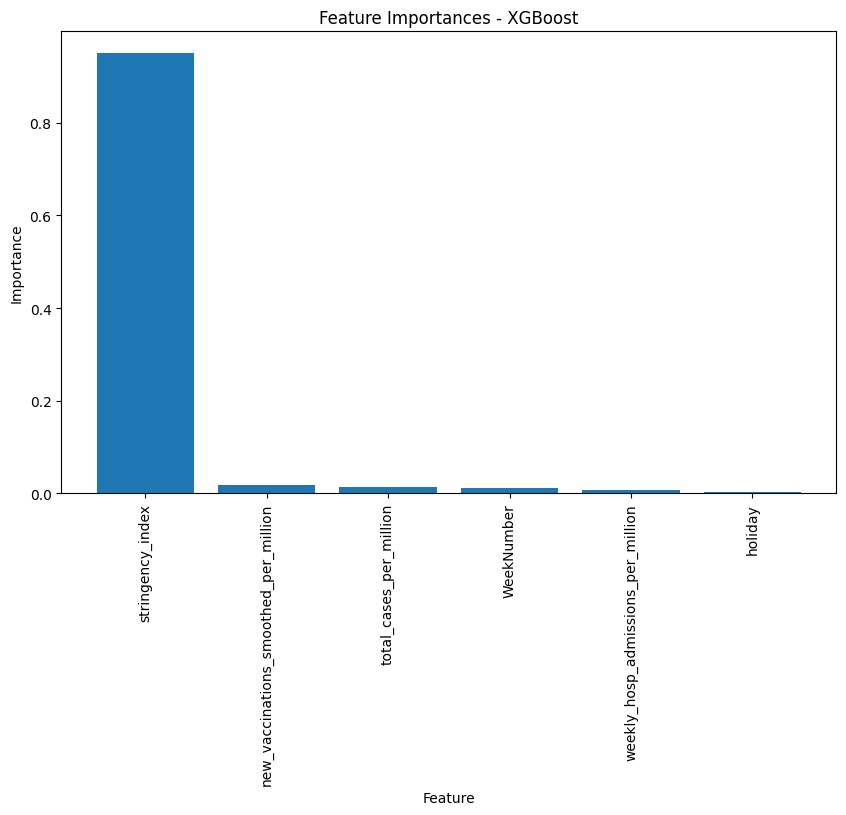

In [42]:
# Create a bar plot of feature importances
plt.figure(figsize=(10, 6))
plt.bar(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importances - XGBoost')
plt.xticks(rotation=90)
plt.show()

In [77]:
# Model 2: Linear Regression
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
linear_pred = linear_model.predict(X_test)
linear_mse = mean_squared_error(y_test, linear_pred)

# Model 3: Random Forest Regression
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_mse = mean_squared_error(y_test, rf_pred)

# Model 4: Support Vector Regression (SVR)
svr_model = SVR()
svr_model.fit(X_train, y_train)
svr_pred = svr_model.predict(X_test)
svr_mse = mean_squared_error(y_test, svr_pred)

# Compare the Mean Squared Error (MSE) of the models
print("XGBoost:", xgboost_mse)
print("Linear Regression MSE:", linear_mse)
print("Random Forest Regression MSE:", rf_mse)
print("SVR MSE:", svr_mse)


XGBoost: 0.21693390434766957
Linear Regression MSE: 0.2489514129377834
Random Forest Regression MSE: 0.23130948704625656
SVR MSE: 1.6551653090721121


In [78]:
#XGBoost has the least Mean Squared Error, followed by Random Forest

In [79]:
#Tuning hyperparameters- XGboost

In [80]:
from sklearn.model_selection import GridSearchCV

# Define the XGBoost regressor
model = xgb.XGBRegressor()

# Define the hyperparameter grid
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Train a new model using the best hyperparameters
best_model = xgb.XGBRegressor(**best_params)
best_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=300, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [81]:
# Make predictions on the test data
y_pred = best_model.predict(X_test)

# Calculate the MSE
mse_tuned_xgboost = mean_squared_error(y_test, y_pred)

# Print the MSE
print("Mean Squared Error:",mse_tuned_xgboost)

Mean Squared Error: 0.22124381829343087


#Interpretation and Findings

* The XGBoost model achieved the most effective performance among the
methods tested, with a mean squared error (MSE) of 0.21. This indicates that the model's predictions deviated from the actual values by an average squared difference of 0.22

* The most important feature in predicting passenger inflow is the stringency_index, with an importance score of approximately 0.95. Higher stringency measures, such as lockdowns or travel restrictions, are associated with reduced passenger inflow.

* The new_vaccinations_smoothed_per_million feature has moderate importance (importance score of around 0.02). A higher rate of new vaccinations per million people may have positively impacted passenger inflow.

* The total_cases_per_million and WeekNumber features have some importance (importance scores around 0.01 each). Higher total COVID-19 cases per million people and specific weeks in the year might influence passenger inflow.

* The weekly_hosp_admissions_per_million and holiday features have relatively lower importance (importance scores around 0.006 and 0.003, respectively). They have a smaller impact on predicting passenger inflow, reflecting the healthcare situation